In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import tensorflow
import tqdm
import glob
import tensorflow as tf
from tqdm import tqdm
from PIL import Image

from skimage.io import imread, imshow
from skimage.transform import resize
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image as img
from google.colab import files
%matplotlib inline

In [2]:
!pip install kaggle

In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle (2).json to kaggle (2).json


In [4]:
!mkdir -p /root/.kaggle/
!cp kaggle.json /root/.kaggle/

In [5]:
!kaggle datasets download -d techsash/waste-classification-data

 99% 425M/427M [00:05<00:00, 123MB/s]
100% 427M/427M [00:05<00:00, 74.7MB/s]


In [6]:
!unzip waste-classification-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/DATASET/TRAIN/R/R_5499.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_55.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_550.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5500.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5501.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5502.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5503.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5504.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5505.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5506.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5507.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5508.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5509.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_551.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5510.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5511.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5512.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5513.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5514.jpg  
  i

In [7]:
train_o = glob.glob('/content/DATASET/TRAIN/O/*.jpg')
a = len(train_o)

In [8]:
train_r = glob.glob('/content/DATASET/TRAIN/R/*.jpg')
b = len(train_r)

In [9]:
# Totalling training images

print("Nos of training samples: {}".format(a+b))

Nos of training samples: 22564


In [10]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2,
                                   )

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2,
                                   )

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   )

In [11]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/DATASET/TRAIN',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 128,
                                                   subset = 'training',
                                                   shuffle = True)

Found 18052 images belonging to 2 classes.


In [12]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/DATASET/TRAIN',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 128,
                                                  subset = 'validation')

Found 4512 images belonging to 2 classes.


In [13]:
# Class Indices

train_dataset.class_indices

{'O': 0, 'R': 1}

100%|██████████| 5/5 [00:20<00:00,  4.20s/it]


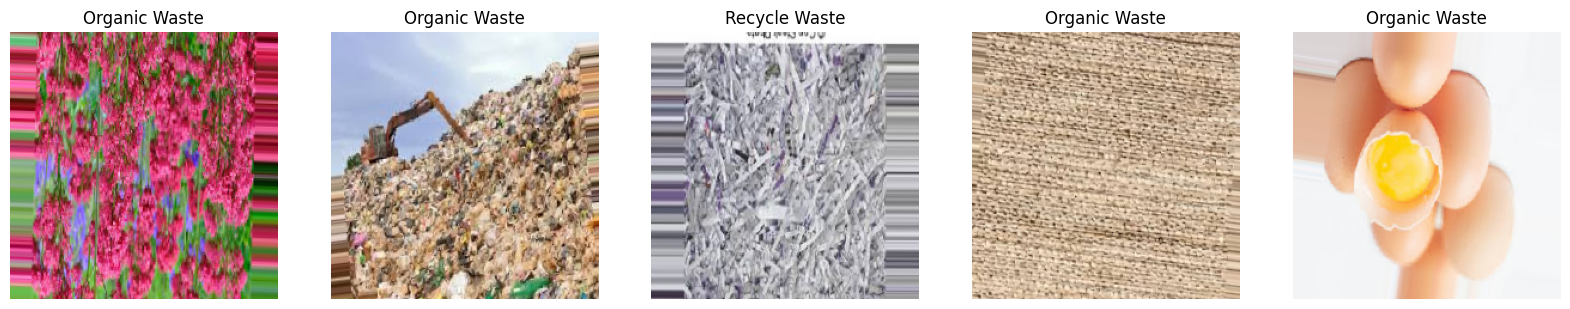

In [14]:
# Viewing Images

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(128)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    label = train_dataset[rand1][1][rand2]
    if label == 1:
        ax[i].set_title('Recycle Waste')
    else:
        ax[i].set_title('Organic Waste')

In [ ]:
# Building model

In [15]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
            input_shape = (224,224, 3),
            include_top = False,
            weights="imagenet"
)

9406464/9406464 [==============================] - 0s 0us/step


In [16]:
for layer in base_model.layers:
    layer.trainable=False

In [17]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [18]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(32, activation = "relu"),
    Dense(64, activation = "relu"),
    Dense(128, activation = "relu"),
    Dropout(0.2),
    Dense(1, activation = "sigmoid")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 32)                40992     
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0

In [19]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [20]:
es = EarlyStopping(patience = 5)

In [21]:
model_history = model.fit(
    train_dataset,
    epochs = 100,
    validation_data = valid_dataset,
    callbacks = [es]
)

Epoch 1/100
142/142 [==============================] - 263s 2s/step - loss: 0.2767 - accuracy: 0.8792 - val_loss: 0.2144 - val_accuracy: 0.9184
Epoch 2/100
142/142 [==============================] - 244s 2s/step - loss: 0.2073 - accuracy: 0.9198 - val_loss: 0.1777 - val_accuracy: 0.9337
Epoch 3/100
142/142 [==============================] - 246s 2s/step - loss: 0.1942 - accuracy: 0.9267 - val_loss: 0.1674 - val_accuracy: 0.9348
Epoch 4/100
142/142 [==============================] - 245s 2s/step - loss: 0.1770 - accuracy: 0.9301 - val_loss: 0.1772 - val_accuracy: 0.9351
Epoch 5/100
142/142 [==============================] - 246s 2s/step - loss: 0.1707 - accuracy: 0.9320 - val_loss: 0.1736 - val_accuracy: 0.9333
Epoch 6/100
142/142 [==============================] - 244s 2s/step - loss: 0.1573 - accuracy: 0.9393 - val_loss: 0.1705 - val_accuracy: 0.9364
Epoch 7/100
142/142 [==============================] - 247s 2s/step - loss: 0.1490 - accuracy: 0.9417 - val_loss: 0.1985 - val_accuracy:

In [22]:
model.save('RecycoolMobileNetV2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
load_model = tf.keras.models.load_model('/content/RecycoolMobileNetV2.h5')

In [24]:
def classify_uploaded_image(model):
    # Upload your image file
    uploaded = files.upload()

    # Save the uploaded file
    for filename in uploaded.keys():
        img_path = filename
        print('Uploaded file:', filename)

        # Load and preprocess the image
        image = Image.open(img_path)
        image = image.resize((224, 224))
        x = np.array(image)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # Make predictions
        predictions = model.predict(x)

        # Display the predictions
        if predictions[0][0] > 0.5:
            print("Predicted class: Class 1 : Recyclable")
        else:
            print("Predicted class: Class 0 : Organic")

# Usage:
classify_uploaded_image(load_model)

Saving 029742300_1634113657-pexels-photo-2547565.webp to 029742300_1634113657-pexels-photo-2547565.webp
Uploaded file: 029742300_1634113657-pexels-photo-2547565.webp
1/1 [==============================] - 1s 1s/step
Predicted class: Class 1 : Recyclable


In [ ]:
#import tensorflow.keras.backend as K

#K.clear_session()
# Define and compile your model again

In [ ]:
# Convert model to TensorFlow Lite

In [25]:
def convert_bytes(num, suffix='B'):

# Convert bytes to a human-readable format.

    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

In [26]:
import os
def get_file_size(file_path):

# Get the size of a file in bytes.

    return os.path.getsize(file_path)

In [27]:
TF_LITE_MODEL_FILE_NAME = 'RecycoolMobileNetV2.tflite'

In [28]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

In [29]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, 'wb').write(tflite_model)

9073668

In [30]:
file_path = '/content/RecycoolMobileNetV2.tflite'
file_size = get_file_size(file_path)
size_in_kb = convert_bytes(file_size, 'KB')

In [31]:
print(f'TensorFlow Lite model size: {size_in_kb}')

TensorFlow Lite model size: 8.7 MiKB


In [ ]:
# Testing model

In [32]:
interpreter = tf.lite.Interpreter(model_path='/content/RecycoolMobileNetV2.tflite')
interpreter.allocate_tensors()

In [33]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

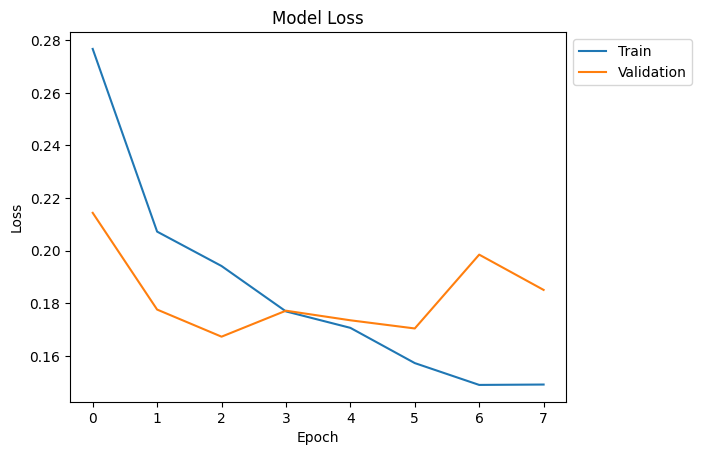

In [34]:
# Summarize the model loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

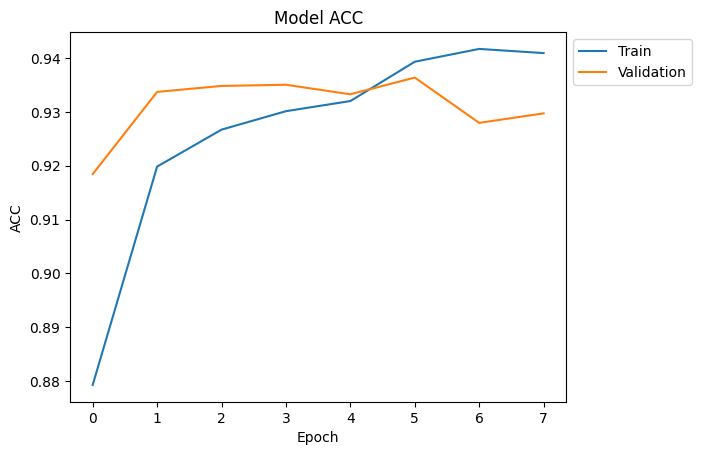

In [35]:
# Summarize models acc

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model ACC')
plt.ylabel('ACC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [39]:
uploaded = files.upload()

Saving TEST.zip to TEST.zip


In [40]:
!unzip TEST.zip -d /content/TESTING_DATA

Archive:  TEST.zip
   creating: /content/TESTING_DATA/TEST/O/
  inflating: /content/TESTING_DATA/TEST/O/O_12568.jpg  
  inflating: /content/TESTING_DATA/TEST/O/O_12569.jpg  
  inflating: /content/TESTING_DATA/TEST/O/O_12570.jpg  
  inflating: /content/TESTING_DATA/TEST/O/O_12571.jpg  
  inflating: /content/TESTING_DATA/TEST/O/O_12572.jpg  
  inflating: /content/TESTING_DATA/TEST/O/O_12573.jpg  
  inflating: /content/TESTING_DATA/TEST/O/O_12574.jpg  
  inflating: /content/TESTING_DATA/TEST/O/O_12575.jpg  
  inflating: /content/TESTING_DATA/TEST/O/O_12576.jpg  
  inflating: /content/TESTING_DATA/TEST/O/O_12577.jpg  
  inflating: /content/TESTING_DATA/TEST/O/O_12578.jpg  
  inflating: /content/TESTING_DATA/TEST/O/O_12579.jpg  
  inflating: /content/TESTING_DATA/TEST/O/O_12580.jpg  
  inflating: /content/TESTING_DATA/TEST/O/O_12581.jpg  
  inflating: /content/TESTING_DATA/TEST/O/O_12582.jpg  
  inflating: /content/TESTING_DATA/TEST/O/O_12583.jpg  
  inflating: /content/TESTING_DATA/TEST/O/

In [43]:
# Test Data

test_data = test_datagen.flow_from_directory(directory = '/content/TESTING_DATA/TEST',
                                             target_size = (224,224),
                                             class_mode = 'binary',
                                             batch_size = 128)

Found 2834 images belonging to 2 classes.


In [44]:
# Evaluating Loss and Acc

model.evaluate(test_data)

23/23 [==============================] - 7s 297ms/step - loss: 0.1695 - accuracy: 0.9305


[0.16952396929264069, 0.9304869174957275]

1/1 [==============================] - 0s 36ms/step
Organic


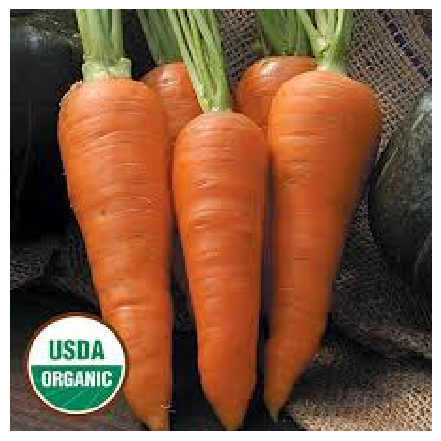

In [46]:
# Test Case:1 - ORGANIC

dic = test_data.class_indices
idc = {k: v for v, k in dic.items()}

img = load_img('/content/TESTING_DATA/TEST/O/O_12582.jpg', target_size=(224, 224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img, axis=0)
prediction = model.predict(img)

if prediction[0][0] > 0.5:
    print("Recyclable")
else:
    print("Organic")

1/1 [==============================] - 0s 63ms/step
Organic


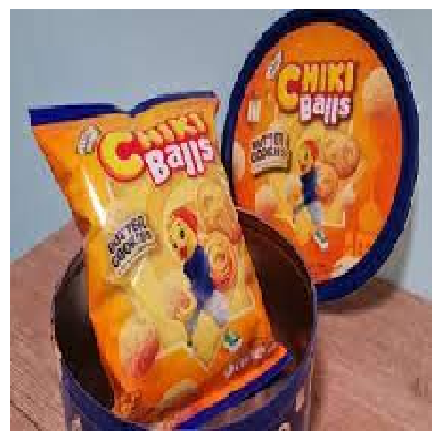

In [48]:
# Test Case:2 - RECYCLEABLE

dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/TESTING_DATA/TEST/R/download (14).jpeg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("Recyclable")
else:
    print("Organic")

#Creating tf.data.Dataset from the DirectoryIterators with images and labels

```
#train_dataset = tf.data.Dataset.from_generator(
    lambda: ((x, y) for x, y in train_dataset),  # Yield both images and labels
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 224, 224, 3], [None]))

    valid_dataset = tf.data.Dataset.from_generator(
    lambda: ((x, y) for x, y in valid_dataset),  # Yield both images and labels
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 224, 224, 3], [None]))

     # Cache and prefetch the dataset
    train_dataset = train_dataset.shuffle(buffer_size=1000).cache().prefetch(tensorflow.data.AUTOTUNE)
    valid_dataset = valid_dataset.cache().prefetch(buffer_size=tensorflow.data.AUTOTUNE)

```




